In [2]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell

import logging
import os
import argparse


parser = argparse.ArgumentParser(description='Main program for sencells')

parser.add_argument('--output_dir', type=str, default='./outputs', help='')
parser.add_argument('--exp_name', type=str, default='', help='')

args = parser.parse_args(args=[])

args.exp_name='s5'

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

logging.basicConfig(format='%(asctime)s.%(msecs)03d [%(levelname)s] [%(filename)s:%(lineno)d] %(message)s',
                    datefmt='# %Y-%m-%d %H:%M:%S')

logging.getLogger().setLevel(logging.DEBUG)
logger = logging.getLogger()

# Part 1: load and process data
# cell_cluster_arr在画umap的时候用
adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data()
# plots.umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_arr,labels=celltype_names)

new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

gene_cell=new_data.X.toarray().T
graph_nx=utils.build_graph_nx(gene_cell,cell_cluster_arr,sen_gene_ls,nonsen_gene_ls,gene_names)
logger.info("Part 1, data loading and processing end!")

# Part 2: generate init embedding
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)
args.device=device

retrain=False
if retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    print(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,os.path.join(args.output_dir,f'{args.exp_name}_gene.emb'))
    torch.save(cell_embed,os.path.join(args.output_dir,f'{args.exp_name}_cell.emb'))
else:
    gene_embed=torch.load(os.path.join(args.output_dir,f'{args.exp_name}_gene.emb'))
    cell_embed=torch.load(os.path.join(args.output_dir,f'{args.exp_name}_cell.emb'))

graph_nx=utils.add_nx_embedding(graph_nx,gene_embed,cell_embed)
graph_pyg=utils.build_graph_pyg(gene_cell,gene_embed,cell_embed)
logger.info("Part 2, AE end!")

# Part 3: train GAT
# graph_pyg=graph_pyg.to('cpu')
args.gene_num=gene_cell.shape[0]
args.cell_num=gene_cell.shape[1]



GAT_model=train_GAT(graph_nx,graph_pyg,args,retrain=False,resampling=False)
logger.info("Part 3, training GAT end!")



from sampling import identify_sencell_marker_graph
from sampling import sub_sampling_by_random
from model_Sencell import cell_optim,update_cell_embeddings,old_cell_optim

from sampling import identify_sengene_then_sencell


all_gene_ls=[]

list_sencell_cover=[]
list_sengene_cover=[]

def get_sencell_cover(old_sencell_dict,sencell_dict):
    set1=set(list(old_sencell_dict.keys()))
    set2=set(list(sencell_dict.keys()))
    set3=set1.intersection(set2)
    print('sencell cover:',len(set3)/len(set2))
    
    return len(set3)/len(set2)

def get_sengene_cover(old_sengene_ls,sengene_ls):
    set1=set(old_sengene_ls)
    set2=set(sengene_ls)
    set3=set1.intersection(set2)
    print('sengene cover:',len(set3)/len(set2))
    
    return len(set3)/len(set2)


cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

# 2022-11-30 21:06:47.769 [INFO] [3507576007.py:53] Part 1, data loading and processing end!


device: cuda:0
the number of edges: 963522
edge index:  torch.Size([2, 963522])
node feature:  torch.Size([12844, 128])
Pyg graph: Data(x=[12844, 128], edge_index=[2, 1927044], y=[12844])


# 2022-11-30 21:06:48.752 [INFO] [3507576007.py:72] Part 2, AE end!
# 2022-11-30 21:06:48.766 [INFO] [3507576007.py:82] Part 3, training GAT end!


graph.is_directed(): False


In [3]:
%%time
import sampling
all_marker_index=sen_gene_ls
    
iteration_results=[]
for iteration in range(5):
    logger.info(f"iteration: {iteration}")
    sampled_graph,sencell_dict,nonsencell_dict,cell_clusters,big_graph_index_dict=sampling.sub_sampling_by_random(graph_nx,
                                                            sen_gene_ls,
                                                            nonsen_gene_ls,
                                                            GAT_model,
                                                            args,
                                                            all_marker_index,
                                                            n_gene=len(all_marker_index),                                                        
                                                            gene_rate=0.3,cell_rate=0.5,
                                                            debug=False)
    break

# 2022-11-30 21:06:48.774 [INFO] [<timed exec>:6] iteration: 0


Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)
After sampling, gene num:  tensor(702)
obj saved ./outputs/s5_cell_score_dict_test
    Sencell num: 200, Nonsencell num: 2000
CPU times: user 1min 30s, sys: 596 ms, total: 1min 30s
Wall time: 1min 30s


cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

# 2022-11-30 21:09:07.316 [DEBUG] [font_manager.py:1329] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
# 2022-11-30 21:09:07.318 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:09:07.318 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:09:07.319 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
# 2022-11-30 21:09:07.320 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
# 2022-11-30 21:09:07.321 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 21:09:07.321 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Deja

# 2022-11-30 21:09:07.361 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:09:07.361 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
# 2022-11-30 21:09:07.362 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:09:07.362 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
# 2022-11-30 21:09:07.363 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:09:07.364 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
# 2022-11-30 21:09:07.364 [DEBUG] [font_manager.py:1

# 2022-11-30 21:09:07.390 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu LGC Sans Mono' (DejaVuLGCSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
# 2022-11-30 21:09:07.390 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:09:07.391 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 21:09:07.391 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:09:07.392 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05
# 2022-11-30 21:09:07.392 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Padauk' (Padauk.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:09:07.393 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX Math' (STIXMath-Regular.otf) normal

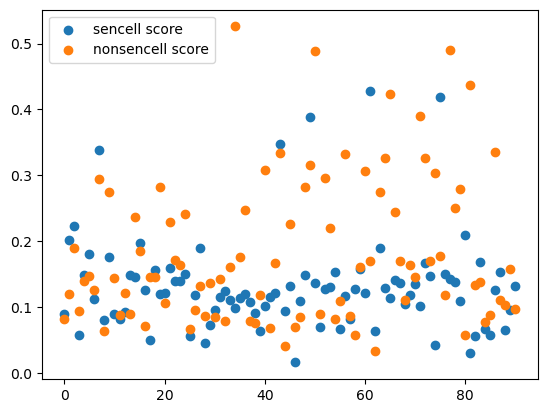

In [4]:
import utils
import scanpy as sp

def get_cell_indexs_for_Fibroblasts():
    data_s5_path="/users/PCON0022/haocheng/Basu_lab/rmarkdown/SCB01S5.h5ad"
    data_new_path='/users/PCON0022/haocheng/Basu_lab/rmarkdown/combined_g8.h5ad'

    data_s5=sp.read_h5ad(data_s5_path)
    data_new=sp.read_h5ad(data_new_path)
    cellnames=[]
    for cellname in data_s5.obs.index:
        if cellname in data_new.obs.index:
            ct1=data_s5.obs.loc[cellname,'ann_level_3_pred']
            ct2=data_new.obs.loc[cellname,'cell_type_seurat']
            if ct1=='Fibroblasts' and ct2=='Fibroblasts-Pericytes':
                # print(data_new.obs.loc[cellname,'disease'])
                cellnames.append(cellname)

    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data()

    all_cell_indexs=list(adata.obs.index)
    cell_indexs=[all_cell_indexs.index(i) for i in cellnames]
    return cell_indexs

def check_cell_scores_s5(cell_indexs,args):
    # cell index是gene_cell矩阵里面cell的index
    cell_score_dict,big_graph_index_dict=utils.load_objs('./outputs/s5_cell_score_dict_test')
    sencell_scores=[]
    nonsencell_scores=[]
    for key,value in big_graph_index_dict.items():
        if value-args.gene_num in cell_indexs:
            sencell_scores.append(cell_score_dict[key][0])
            nonsencell_scores.append(cell_score_dict[key][1])
            
    return sencell_scores,nonsencell_scores


cell_indexs=get_cell_indexs_for_Fibroblasts()

sencell_scores,nonsencell_scores=check_cell_scores_s5(cell_indexs,args)


plt.scatter(range(len(sencell_scores)),sencell_scores,label='sencell score')
plt.scatter(range(len(nonsencell_scores)),nonsencell_scores,label='nonsencell score')

plt.legend()

cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

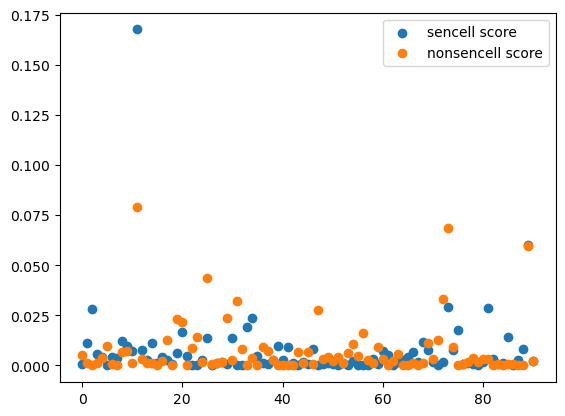

In [6]:
import utils
import scanpy as sp

def get_cell_indexs_for_Fibroblasts():
    data_s5_path="/users/PCON0022/haocheng/Basu_lab/rmarkdown/SCB01S5.h5ad"
    data_new_path='/users/PCON0022/haocheng/Basu_lab/rmarkdown/combined_g8.h5ad'

    data_s5=sp.read_h5ad(data_s5_path)
    data_new=sp.read_h5ad(data_new_path)
    cellnames=[]
    for cellname in data_s5.obs.index:
        if cellname in data_new.obs.index:
            ct1=data_s5.obs.loc[cellname,'ann_level_3_pred']
            ct2=data_new.obs.loc[cellname,'cell_type_seurat']
            if ct1=='Fibroblasts' and ct2=='Fibroblasts-Pericytes':
                # print(data_new.obs.loc[cellname,'disease'])
                cellnames.append(cellname)

    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data()

    all_cell_indexs=list(adata.obs.index)
    cell_indexs=[all_cell_indexs.index(i) for i in cellnames]
    return cell_indexs

def check_cell_scores_disease(cell_indexs,args):
    # cell index是gene_cell矩阵里面cell的index
    cell_score_dict,big_graph_index_dict=utils.load_objs('./outputs/disease_cell_score_dict_test')
    sencell_scores=[]
    nonsencell_scores=[]
    for key,value in big_graph_index_dict.items():
        if value-args.gene_num in cell_indexs:
            sencell_scores.append(cell_score_dict[key][0])
            nonsencell_scores.append(cell_score_dict[key][1])
            
    return sencell_scores,nonsencell_scores


cell_indexs=get_cell_indexs_for_Fibroblasts()

sencell_scores,nonsencell_scores=check_cell_scores_disease(cell_indexs,args)


plt.scatter(range(len(sencell_scores)),sencell_scores,label='sencell score')
plt.scatter(range(len(nonsencell_scores)),nonsencell_scores,label='nonsencell score')

plt.legend()

In [5]:
cell_score_dict,big_graph_index_dict=utils.load_objs('./outputs/s5_cell_score_dict_test')

In [6]:
import numpy as np
cell_scores=np.array(list(cell_score_dict.values()))

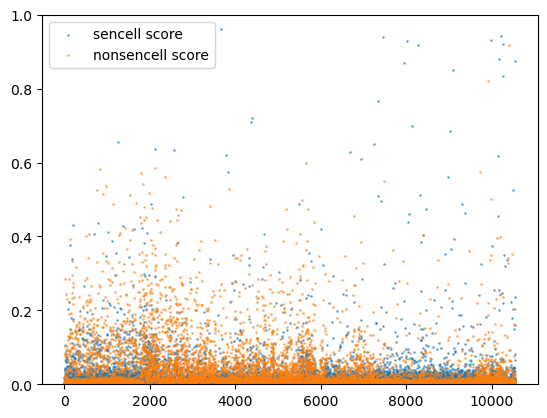

In [7]:
plt.scatter(range(len(cell_scores[:,0])),cell_scores[:,0],label='sencell score',s=1,alpha=0.5)
plt.scatter(range(len(cell_scores[:,0])),cell_scores[:,1],label='nonsencell score',s=1,alpha=0.5)
plt.ylim(0,1)
plt.legend()

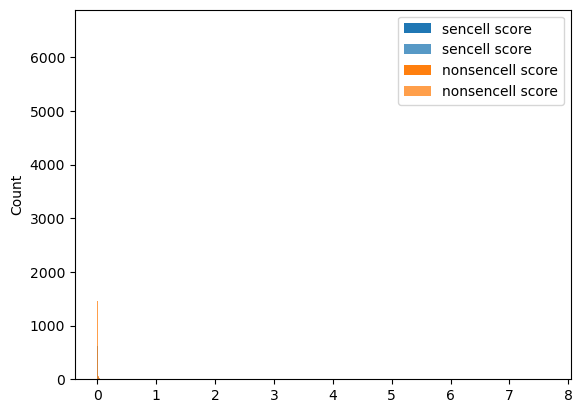

In [11]:
sns.histplot(cell_scores[:,0],label='sencell score')
sns.histplot(cell_scores[:,1],label='nonsencell score')
plt.legend()

In [16]:
sum(cell_scores[:,0]>cell_scores[:,1])

8160

cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

# 2022-11-30 07:52:21.867 [DEBUG] [font_manager.py:1329] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
# 2022-11-30 07:52:21.868 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 07:52:21.869 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 07:52:21.870 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
# 2022-11-30 07:52:21.871 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
# 2022-11-30 07:52:21.871 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 07:52:21.872 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Deja

# 2022-11-30 07:52:21.910 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 07:52:21.910 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
# 2022-11-30 07:52:21.911 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 07:52:21.911 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
# 2022-11-30 07:52:21.912 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 07:52:21.913 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
# 2022-11-30 07:52:21.913 [DEBUG] [font_manager.py:1

# 2022-11-30 07:52:21.938 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu LGC Sans Mono' (DejaVuLGCSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
# 2022-11-30 07:52:21.939 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 07:52:21.939 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 07:52:21.940 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335
# 2022-11-30 07:52:21.940 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05
# 2022-11-30 07:52:21.941 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Padauk' (Padauk.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 07:52:21.941 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX Math' (STIXMath-Regular.otf) normal

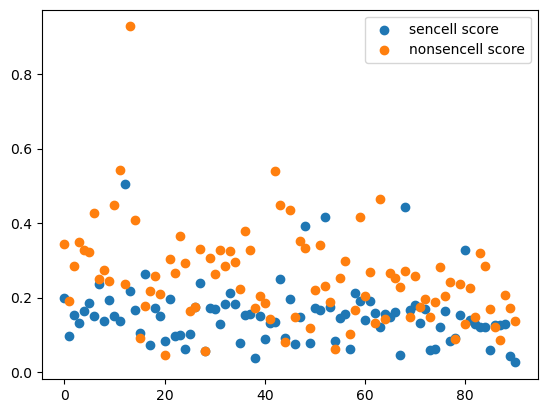

In [3]:
# s5

In [19]:
sum(np.array(sencell_scores)>np.array(nonsencell_scores))

18